**Imports Required for notebook to work.**

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Computational Neurodynamics
This is the research area for my computational neurodynamics work.

In [31]:
excitary_neuron_params_izhikevich = {
    "a": 0.02,
    "b": 0.2,
    "c": -65,
    "d": 5
}

inhibitary_neuron_params_izhikevich = {
    "a": 0.02,
    "b": 0.25,
    "c": -65,
    "d": 2
}

# Izhikevich Neurones
The goal here is to create a neurone, this neurone gets initialised with an initial configuration (can't be changed). This handles receiving current from input sources and then an update function which should be called every 1 ms to determine the next values for v and u.

The neurone just stores current state, has no idea of previous states or the things it's been connected too. This will be incorporated in the synapse and population classes.

In [32]:
MAX_NEURONE_MEMBRANE_POTENTIAL = 30 # Hyper parameter ready for tweaking

def get_maximum_neurone_potential():
    # Incase I want this to be variable value i.e. between 30 and 40.
    return MAX_NEURONE_MEMBRANE_POTENTIAL

class IzhikevichNeurone:
    def __init__(self, initial_v, initial_u, a, b, c, d):
        self.v_now = initial_v
        self.u_now = initial_u
        self.I_now = 0
        self.timestep = 0 # in ms
        self._max_neurone_potential = get_maximum_neurone_potential()
        self.firing = False
        self._a = a
        self._b = b
        self._c = c
        self._d = d

        self.I_now = 0
        self.timestep = 0 # in ms
        self._max_neurone_potential = get_maximum_neurone_potential()
        self.firing = False

    def receive_current(self, current_amount):
        self.I_now += current_amount

    def is_firing(self):
        return self.firing

    def update(self, external_current, delta_t = 0.01):
        self.I_now += external_current # This will probably be the background current
        # Handle Neurone Update - Izchi

        # Setup Differential Equations
        dv_dt = lambda v, u, I: 0.04 * v * v + 5 * v + 140 - u + I
        du_dt = lambda a, b, v, u: a * (b * v - u)

        current_dv = dv_dt(self.v_now, self.u_now, self.I_now)
        current_du = du_dt(self._a, self._b, self.v_now, self.u_now)

        self.v_now = self.v_now + delta_t * current_dv
        self.u_now = self.u_now + delta_t * current_du

        # If it's reached the membrane potential reset.
        if self.v_now >= self._max_neurone_potential:
            # Question: Maybe set firing to be true here? for this timestep
            self.v_now = self._c
            self.u_now = self.u_now + self._d
            self.firing = True
        else:
            self.firing = False

        # Reset Current
        self.I_now = 0

        return self.v_now, self.u_now, self.firing

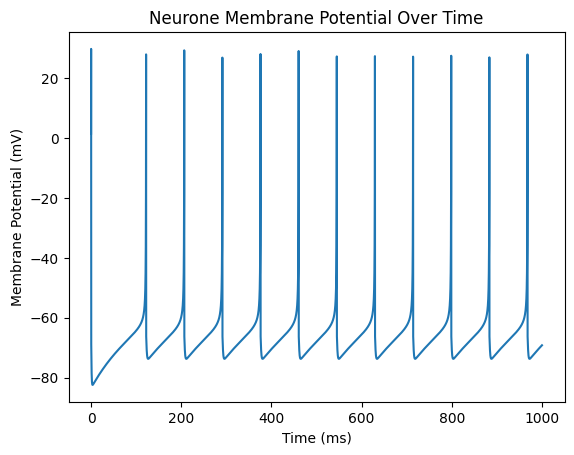

In [33]:
class TestIzhikevichNeurone:
    def __init__(self, a, b, c, d, initial_v=0.0, initial_u=0.0, simulation_time=100, delta_t=0.01):
        self.neurone = IzhikevichNeurone(initial_v, initial_u, a, b, c, d)
        self.simulation_time = simulation_time
        self.delta_t = delta_t
        self.time_points = []
        self.v_values = []

    def apply_constant_current(self, current):
        for t in range(int(self.simulation_time / self.delta_t)):
            self.time_points.append(t * self.delta_t)
            v, _, _ = self.neurone.update(external_current=current, delta_t=self.delta_t)
            self.v_values.append(v)

    def plot_neurone_behavior(self):
        plt.plot(self.time_points, self.v_values)
        plt.title('Neurone Membrane Potential Over Time')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.show()

    def run_tests(self):
        # Test with constant background current
        self.apply_constant_current(5)  # You can vary this current for different simulations
        self.plot_neurone_behavior()
        # Reset for next test
        self.time_points = []
        self.v_values = []

# Usage
tester = TestIzhikevichNeurone(a=0.02, b=0.2, c=-65, d=6, simulation_time=1000)
tester.run_tests()

# Synapse
To connect two neurones we have to introduce this idea of a synapse. This is the connection between two neurones. This is where we track important features like
- What's the pre-synaptic neurone and the post-synaptic neurone?
- How much current are we sending to the post synpatic neurone?
- How are we going to handle the conduction delay between neurone signal transmission.

In [ ]:
class Synapse:
    def __init__(self, pre_synaptic_neurone, post_synaptic_neurone, weight, conduction_delay, scaling_factor):
        self.pre_synaptic_neurone = pre_synaptic_neurone
        self.post_synaptic_neurone = post_synaptic_neurone
        self.weight = weight
        self.scaling_factor = scaling_factor
        self.conduction_delay = conduction_delay
        self.conduction_queue = [0 for _ in range(conduction_delay)]
        self.synaptic_efficacy = 0
        self.decay_factor = random.uniform(0.985, 0.995) # How much current gets passed after delta_t


    def update(self):
        # Apply decay to the current synaptic efficacy
        self.synaptic_efficacy *= self.decay_factor

        # Check if a new spike has arrived
        if len(self.conduction_queue)>0 and self.conduction_queue.pop(0):
            # Add the effect of a new spike
            self.synaptic_efficacy += 1  # This could be a fixed value or based on some other calculation

        # Apply the current synaptic efficacy to the post-synaptic neuron, scaled by weight and other factors
        self.post_synaptic_neurone.receive_current(self.synaptic_efficacy * self.weight * self.scaling_factor)

        # Handle the pre-synaptic neuron firing
        if self.pre_synaptic_neurone.is_firing():
            # Enqueue the spike after the conduction delay
            self.conduction_queue += [1] + [0] * (self.conduction_delay - 1)

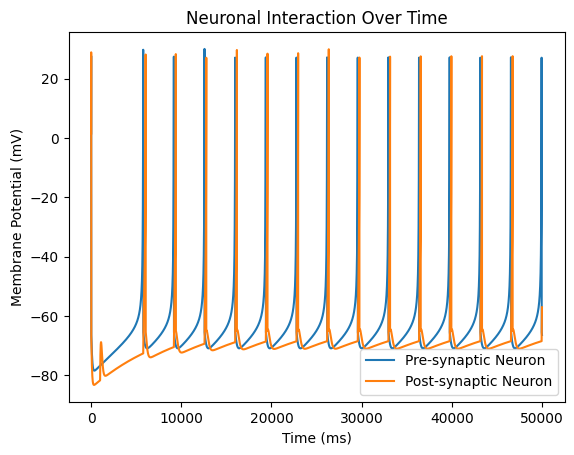

In [35]:
class TestSynapse:
    def __init__(self, pre_params, post_params, weight, simulation_time=100, delta_t=0.01):
        # Initialize pre-synaptic and post-synaptic neurons with their respective parameters
        self.pre_neurone = IzhikevichNeurone(*pre_params)
        self.post_neurone = IzhikevichNeurone(*post_params)

        # Simulation parameters
        self.simulation_time = simulation_time
        self.delta_t = delta_t
        self.weight = weight

        # Recordings for plotting
        self.time_points = []
        self.pre_v_values = []
        self.post_v_values = []

    def run_simulation(self, background_current):
        synapse = Synapse(self.pre_neurone, self.post_neurone, random.random(), int(10/self.delta_t), 50)

        for i in range(int(self.simulation_time/self.delta_t)):
            self.time_points.append(i)
            # Update the pre and post synaptic neurone
            pre_v_value, _, _ = self.pre_neurone.update(background_current, delta_t=self.delta_t)
            post_v_value, _, _ = self.post_neurone.update(0, delta_t=self.delta_t)

            # Add the values
            self.pre_v_values.append(pre_v_value)
            self.post_v_values.append(post_v_value)

            # Handle transmission in this synapse.
            synapse.update()


    def plot_synaptic_behavior(self):
        plt.plot(self.time_points, self.pre_v_values, label='Pre-synaptic Neuron')
        plt.plot(self.time_points, self.post_v_values, label='Post-synaptic Neuron')
        plt.title('Neuronal Interaction Over Time')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.legend()
        plt.show()



    def run_tests(self):
        # Run simulation with specified current for pre and post neurons
        self.run_simulation(background_current=10)
        self.plot_synaptic_behavior()

# Usage example
pre_params = (0.02, 0.2, excitary_neuron_params_izhikevich['a'], excitary_neuron_params_izhikevich['b'], excitary_neuron_params_izhikevich['c'], excitary_neuron_params_izhikevich['d'])
post_params = (0.1, 0.2, inhibitary_neuron_params_izhikevich['a'], inhibitary_neuron_params_izhikevich['b'], inhibitary_neuron_params_izhikevich['c'], inhibitary_neuron_params_izhikevich['d'])

tester = TestSynapse(pre_params, post_params, weight=0.5, simulation_time=500)
tester.run_tests()


# Neural Network
This is a simple class that connects neurones together to help me determine how to get a decent setup.
Essentially what we are building here is a Watts-Strogatz network. So i'm passing in some random connectivity in here. This is going to be the foundation for our actual network, with the parameter tweaking.

In [36]:
import random

class NeuralNetwork:
    def __init__(self, num_neurons, connectivity=0.1, delta_t=0.01):
        self.neurons = [IzhikevichNeurone(*self.random_parameters()) for _ in range(num_neurons)]
        self.synapses = []
        self.delta_t = delta_t
        self.connect_neurons(connectivity, delta_t)
        self.recordings_v = [[] for _ in range(num_neurons)]
        self.recordings_u = [[] for _ in range(num_neurons)]

    def random_parameters(self):
        # Common parameter ranges
        a_range = (0.02, 0.1)  # Range for the 'a' parameter
        b_range = (0.2, 0.25)  # Range for the 'b' parameter for excitatory neurons
        b_inhibitory_range = (0.25, 0.3)  # 'b' for inhibitory neurons
        c_range = (-65, -50)  # Range for the 'c' parameter
        d_range = (2, 8)  # Range for the 'd' parameter for excitatory neurons
        d_inhibitory_range = (1, 4)  # 'd' for inhibitory neurons

        # Randomly decide if the neuron is excitatory or inhibitory
        inhibitory = random.random() > 0.8

        # 'a' parameter
        a = random.uniform(*a_range)

        # 'b' parameter, depends on neuron type
        if inhibitory:
            b = random.uniform(*b_inhibitory_range)
        else:
            b = random.uniform(*b_range)

        # 'c' parameter
        c = random.uniform(*c_range)

        # 'd' parameter, depends on neuron type
        if inhibitory:
            d = random.uniform(*d_inhibitory_range)
        else:
            d = random.uniform(*d_range)

        # Initial values for v and u
        v_init = random.uniform(-65, -60)  # Typical initial membrane potential range
        u_init = b * v_init  # Initialize u based on the chosen 'b' to keep it in a reasonable range

        return v_init, u_init, a, b, c, d

    def connect_neurons(self, connectivity, delta_t):
        for i, pre_neuron in enumerate(self.neurons):
            for j, post_neuron in enumerate(self.neurons):
                if i != j and random.random() < connectivity:
                    self.synapses.append(Synapse(pre_neuron, post_neuron, 1, conduction_delay=
                    int(random.randint(1, 20) / self.delta_t), scaling_factor=17))

    def update(self):
        # Update all neurons, then update all synapses
        for i, neuron in enumerate(self.neurons):
            external_current = 15 if np.random.poisson(0.01) > 0 else 0
            v, u, is_firing = neuron.update(delta_t=self.delta_t, external_current=external_current)
            # Append the current v and u values to their respective recordings
            self.recordings_v[i].append(v)
            self.recordings_u[i].append(u)
        for synapse in self.synapses:
            synapse.update()

    def run_simulation(self, simulation_time):
        total_steps = int(simulation_time / self.delta_t)
        for t in range(total_steps):
            self.update()
            # Progress bar
            progress = (t + 1) / total_steps
            print(f'\rSimulation progress: {progress:.2%}', end='')

    def plot_neuron_activity(self, neuron_index):
        plt.figure(figsize=(14, 6))

        plt.subplot(2, 1, 1)
        plt.plot(self.recordings_v[neuron_index], label=f'Neuron {neuron_index} Membrane Potential (v)')
        plt.title(f'Neuron {neuron_index} Activity')
        plt.ylabel('Membrane Potential (v)')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(self.recordings_u[neuron_index], label=f'Neuron {neuron_index} Recovery Variable (u)')
        plt.xlabel('Time Steps')
        plt.ylabel('Recovery Variable (u)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_neurons(self):
        for v_record in self.recordings_v:
            plt.plot(v_record)
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Membrane Potential Over Time for All Neurons')
        plt.show()

# Now you can create a network with, say, 100 excitatory neurons and a connectivity of 10%
network = NeuralNetwork(num_neurons=100, connectivity=0.1, delta_t=0.01)
network.run_simulation(simulation_time=1000)


Simulation progress: 12.18%

KeyboardInterrupt: 

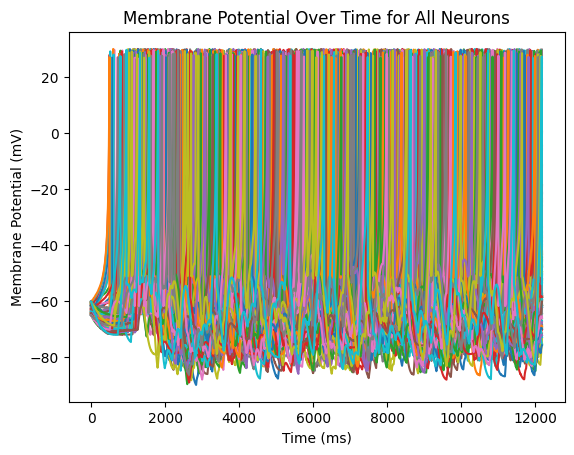

In [37]:
for v_record in network.recordings_v:
    plt.plot(v_record)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential Over Time for All Neurons')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming network.recordings_v is a list of lists, with each sub-list containing the membrane potentials over time for a neuron
data = np.array(network.recordings_v)  # Convert it to a NumPy array for easier manipulation

# Set up the figure
plt.figure(figsize=(15, 10))

# Use imshow to create the heatmap
# 'aspect' can be set to 'auto' to let the x and y scales adjust automatically to fill the figure
# 'origin' is set to 'lower' to place the [0,0] index of the array in the bottom left corner of the axes
plt.imshow(data, aspect='auto', origin='lower', cmap='viridis', interpolation='none')

# Add a colorbar to show the mapping of color intensity to membrane potential
plt.colorbar(label='Membrane Potential (mV)')

# Label the axes
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')

# Add a title
plt.title('Membrane Potential Over Time for All Neurons')

# Show the plot
plt.show()


# Refactoring for CourseWork

We need each neuron to be types and id'd so we can track which module it belongs to and automatically configure the parameters required to do the next bits.

We are building 8 communities of 200 excitatory neurones. These will form a Modular Small World Network, with rewiring probaility p.

Then we're building a pool of inhibitory neurones. These are connected to every neurone. Also four neurones from each of the 8 communities are selected to attatch to every inhibitory neurone in the pool.

I need to be able to plot the Connectivity Matrix, the raster plot nad mean firing rate.

In [132]:
from threading import Lock

def get_neurone_parameters(is_inhibitory):
    r = random.random()
    if is_inhibitory:
        return 0.02 + 0.08 * r, 0.25 - 0.05 * r, -65, 2
    return 0.02, 0.2, -65 + 15*(r**2), 8 - 6*(r**2)

def get_neurone_params_old(is_inhibitory):
    # Common parameter ranges
    a_range = (0.02, 0.1)  # Range for the 'a' parameter
    b_range = (0.2, 0.25)  # Range for the 'b' parameter for excitatory neurons
    b_inhibitory_range = (0.25, 0.3)  # 'b' for inhibitory neurons
    c_range = (-65, -50)  # Range for the 'c' parameter
    d_range = (2, 8)  # Range for the 'd' parameter for excitatory neurons
    d_inhibitory_range = (1, 4)  # 'd' for inhibitory neurons
    # 'a' parameter
    a = random.uniform(*a_range)

    # 'b' parameter, depends on neuron type
    if is_inhibitory:
        b = random.uniform(*b_inhibitory_range)
    else:
        b = random.uniform(*b_range)

    # 'c' parameter
    c = random.uniform(*c_range)

    # 'd' parameter, depends on neuron type
    if is_inhibitory:
        d = random.uniform(*d_inhibitory_range)
    else:
        d = random.uniform(*d_range)

    return a, b, c, d

class Neurone:
    def __init__(self, neurone_type, neurone_id):
        assert neurone_type == "EXCITATORY" or neurone_type == "INHIBITORY"
        # Randomly decide if the neuron is excitatory or inhibitory
        inhibitory = neurone_type == "INHIBITORY"

        a, b, c, d = get_neurone_parameters(inhibitory)

        # Initial values for v and u
        v_init = random.uniform(-65, -60)  # Typical initial membrane potential range
        u_init = -1  # Initialize u based on the chosen 'b' to keep it in a reasonable range

        self.v_now = v_init
        self.u_now = u_init
        self.neurone_type = neurone_type
        self.neurone_id = neurone_id
        self.I_now = 0
        self.timestep = 0 # in ms
        self._max_neurone_potential = get_maximum_neurone_potential()
        self.firing = False
        self._a = a
        self._b = b
        self._c = c
        self._d = d
        self.lock = Lock()

    def receive_current(self, current_amount):
        with self.lock:
            self.I_now += current_amount

    def is_firing(self):
        return self.firing

    def update(self, external_current, delta_t = 0.01):
        self.I_now += external_current # This will probably be the background current
        # Handle Neurone Update - Izchi

        # Setup Differential Equations
        dv_dt = lambda v, u, I: 0.04 * v * v + 5 * v + 140 - u + I
        du_dt = lambda a, b, v, u: a * (b * v - u)

        current_dv = dv_dt(self.v_now, self.u_now, self.I_now)
        current_du = du_dt(self._a, self._b, self.v_now, self.u_now)

        self.v_now = self.v_now + delta_t * current_dv
        self.u_now = self.u_now + delta_t * current_du

        # If it's reached the membrane potential reset.
        if self.v_now >= self._max_neurone_potential:
            # Question: Maybe set firing to be true here? for this timestep
            self.v_now = self._c
            self.u_now = self.u_now + self._d
            self.firing = True
        else:
            self.firing = False

        # Reset Current
        self.I_now = 0

        return self.v_now, self.u_now, self.firing

# Neurone Test

Testing a EXCITATORY neuron with constant current: 15


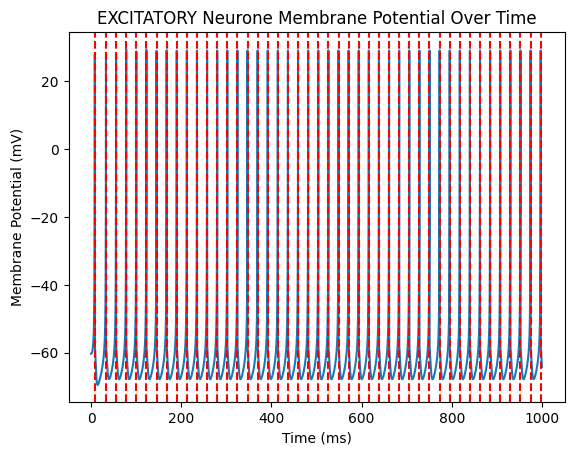

Testing a INHIBITORY neuron with constant current: 15


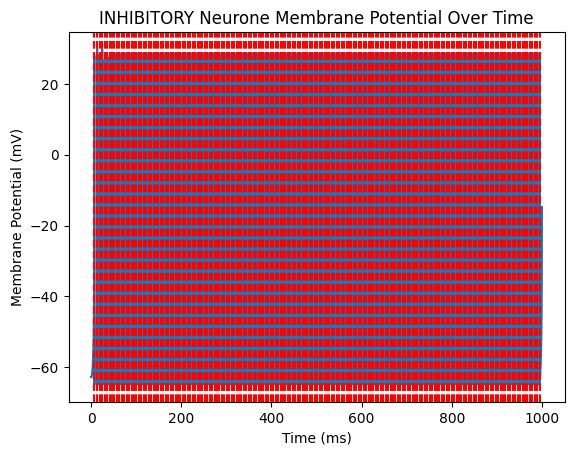

In [123]:
# Test class for the Neurone
class TestNeurone:
    def __init__(self, neurone_type, simulation_time=1000, delta_t=0.01):
        # Create an instance of Neurone with random parameters
        self.neurone = Neurone(neurone_type, neurone_id=0)
        self.simulation_time = simulation_time
        self.delta_t = delta_t
        self.time_points = []
        self.v_values = []
        self.firing_times = []

    def apply_constant_current(self, current):
        for t in range(int(self.simulation_time / self.delta_t)):
            self.time_points.append(t * self.delta_t)
            v, u, is_firing = self.neurone.update(external_current=current, delta_t=self.delta_t)
            self.v_values.append(v)
            if is_firing:
                self.firing_times.append(t * self.delta_t)

    def plot_neurone_behavior(self):
        plt.plot(self.time_points, self.v_values)
        for firing_time in self.firing_times:
            plt.axvline(x=firing_time, color='r', linestyle='--')
        plt.title(f'{self.neurone.neurone_type} Neurone Membrane Potential Over Time')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.show()

    def run_tests(self, current):
        print(f"Testing a {self.neurone.neurone_type} neuron with constant current: {current}")
        self.apply_constant_current(current)
        self.plot_neurone_behavior()

# Usage
exc_tester = TestNeurone("EXCITATORY")
inh_tester = TestNeurone("INHIBITORY")

# Apply a constant current that is known to induce spikes in these types of neurons
exc_tester.run_tests(current=15)  # Adjust the current as needed
inh_tester.run_tests(current=15)  # Adjust the current as needed


In [179]:
from collections import deque


def get_synapse_params(pre_neurone_type, post_neurone_type):
    if pre_neurone_type == "EXCITATORY":
        if post_neurone_type == "INHIBITORY":
            return random.random(), 50, 1
        else:
            return 1, 17, random.randint(1,20)
    else:
        if post_neurone_type == "INHIBITORY":
            return -random.random(), 1, 1
        else:
            return -random.random(), 2, 1

class TypedSynapse:
    def __init__(self, pre_neurone, post_neurone, delta_t):
        self.pre_synaptic_neurone = pre_neurone
        self.post_synaptic_neurone = post_neurone
        self.delta_t = delta_t

        self.weight, self.scaling_factor, self.conduction_delay = get_synapse_params(
            pre_neurone.neurone_type, post_neurone.neurone_type
        )
        self.conduction_delay = int(self.conduction_delay / delta_t)
        from collections import deque
        self.conduction_queue = deque([], maxlen=self.conduction_delay)
        self.synaptic_efficacy = 0
        self.decay_factor = 0.999

    def rewire_synapse(self, pre_neurone, post_neurone):
        self.pre_synaptic_neurone = pre_neurone
        self.post_synaptic_neurone = post_neurone

        self.weight, self.scaling_factor, self.conduction_delay = get_synapse_params(
            pre_neurone.neurone_type, post_neurone.neurone_type
        )
        self.conduction_delay = int(self.conduction_delay / self.delta_t)
        self.conduction_queue = [0 for _ in range(self.conduction_delay)]

    def update(self):
        # Apply decay to the current synaptic efficacy
        self.synaptic_efficacy *= self.decay_factor

        # Check if a new spike has arrived
        if self.conduction_queue and self.conduction_queue.popleft():
            # Add the effect of a new spike
            self.synaptic_efficacy += self.weight  # Use weight as the increase for a spike

        # Apply the current synaptic efficacy to the post-synaptic neuron, scaled by weight and other factors
        self.post_synaptic_neurone.receive_current(self.synaptic_efficacy * self.scaling_factor)

        # Handle the pre-synaptic neuron firing
        if self.pre_synaptic_neurone.is_firing():
            self.conduction_queue.extend([1] + [0] * (self.conduction_delay - 1))


# Synapse Test Suite

Testing synapse with EXCITATORY -> INHIBITORY


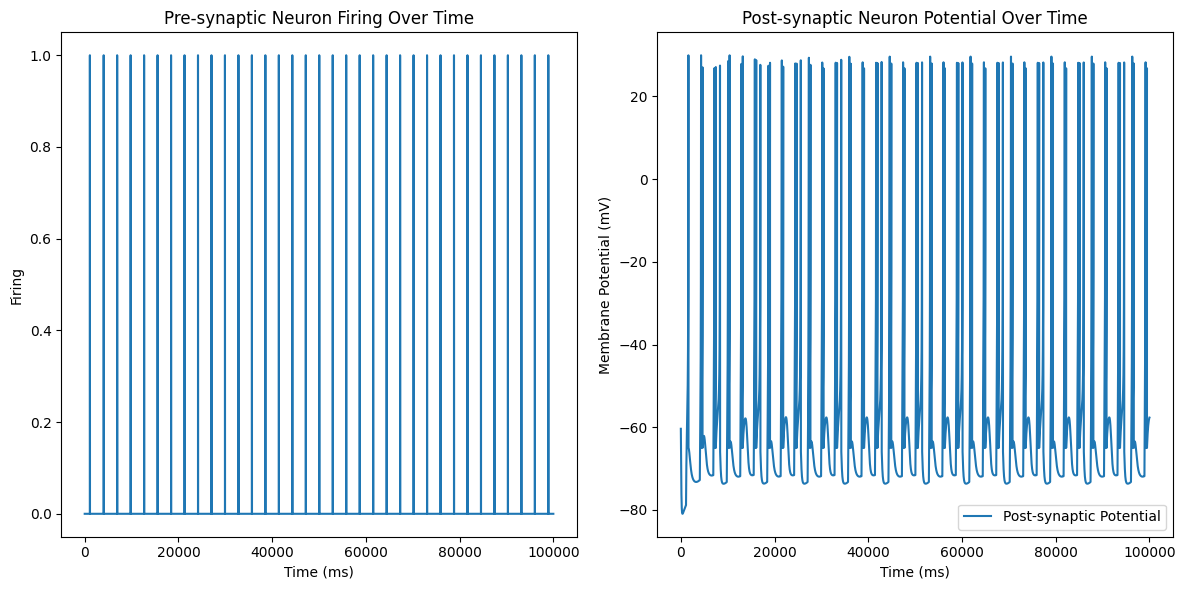

Testing synapse with INHIBITORY -> INHIBITORY


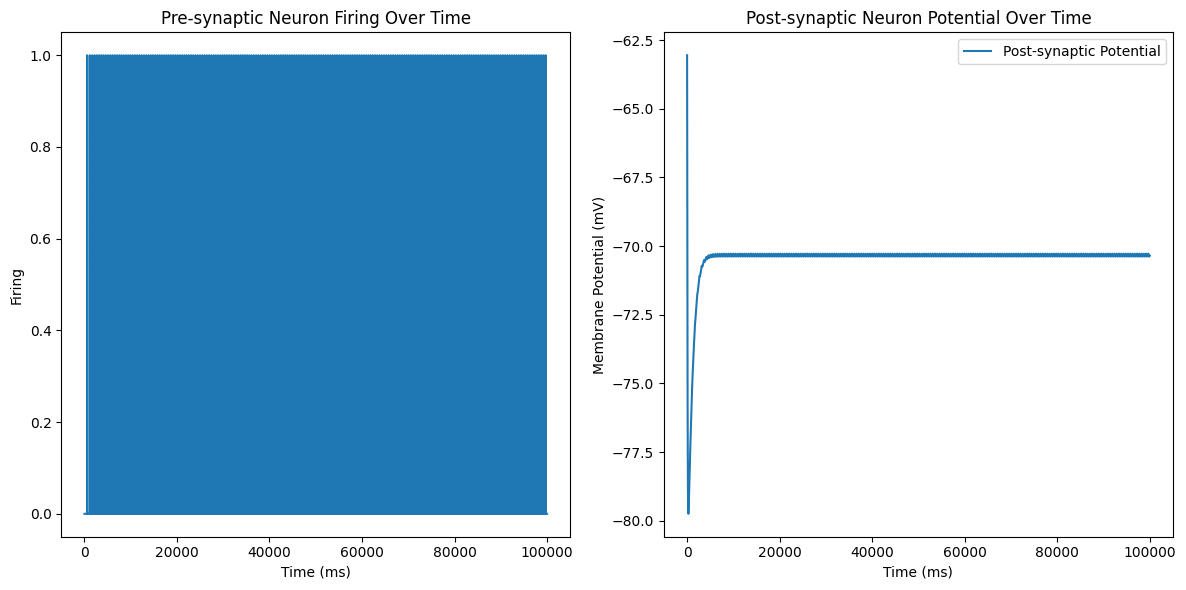

Testing synapse with EXCITATORY -> EXCITATORY


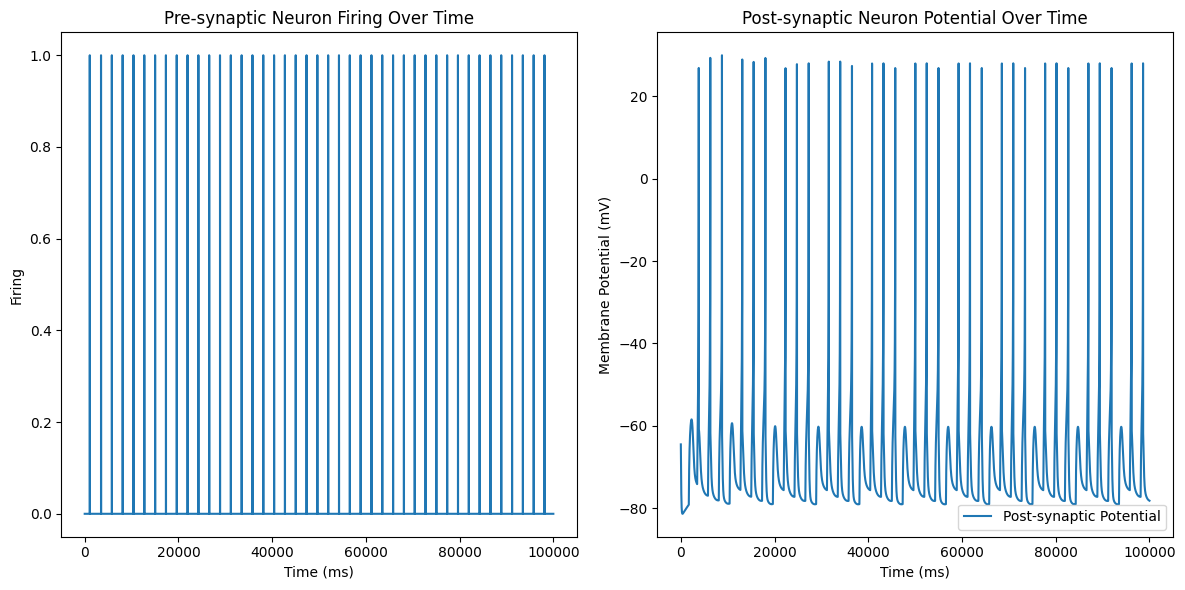

Testing synapse with INHIBITORY -> EXCITATORY


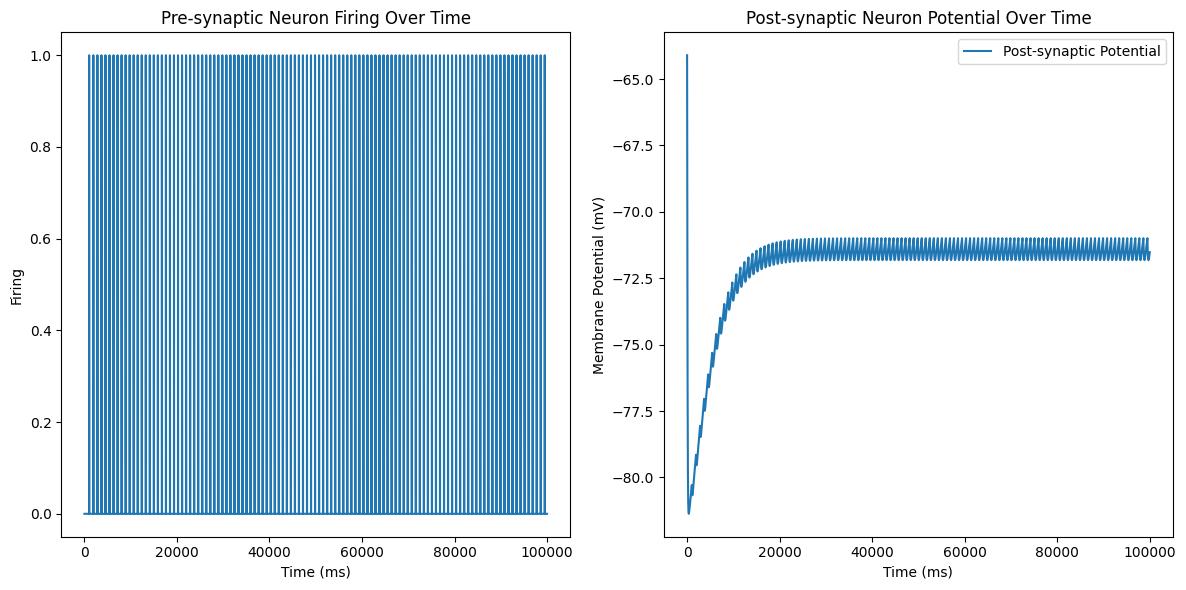

Testing synapse with INHIBITORY -> EXCITATORY


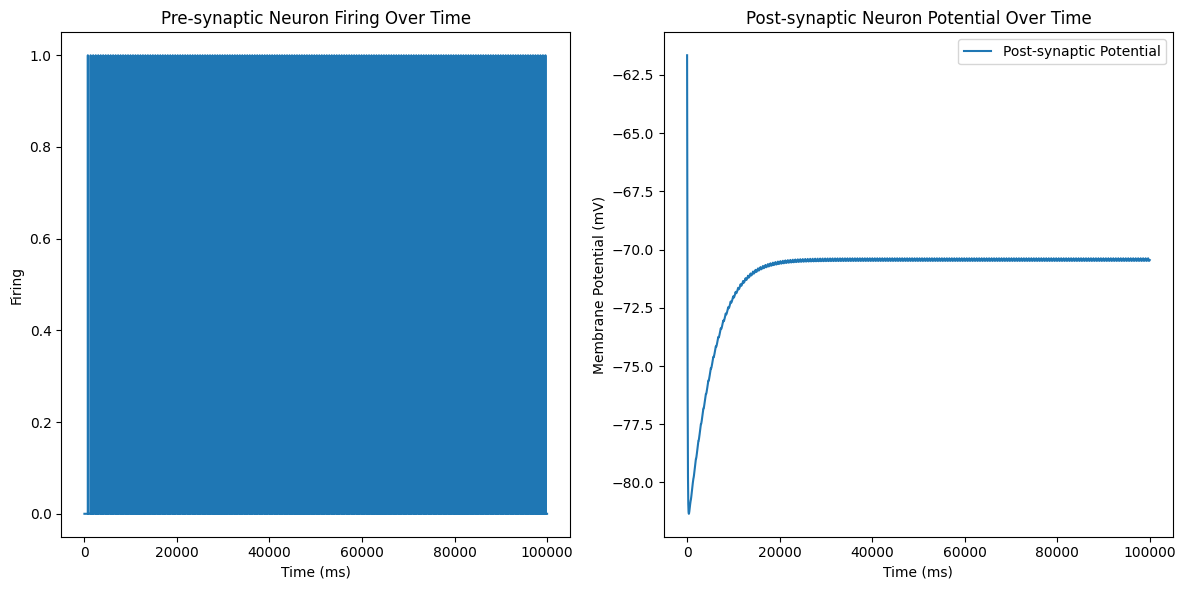

Testing synapse with INHIBITORY -> EXCITATORY


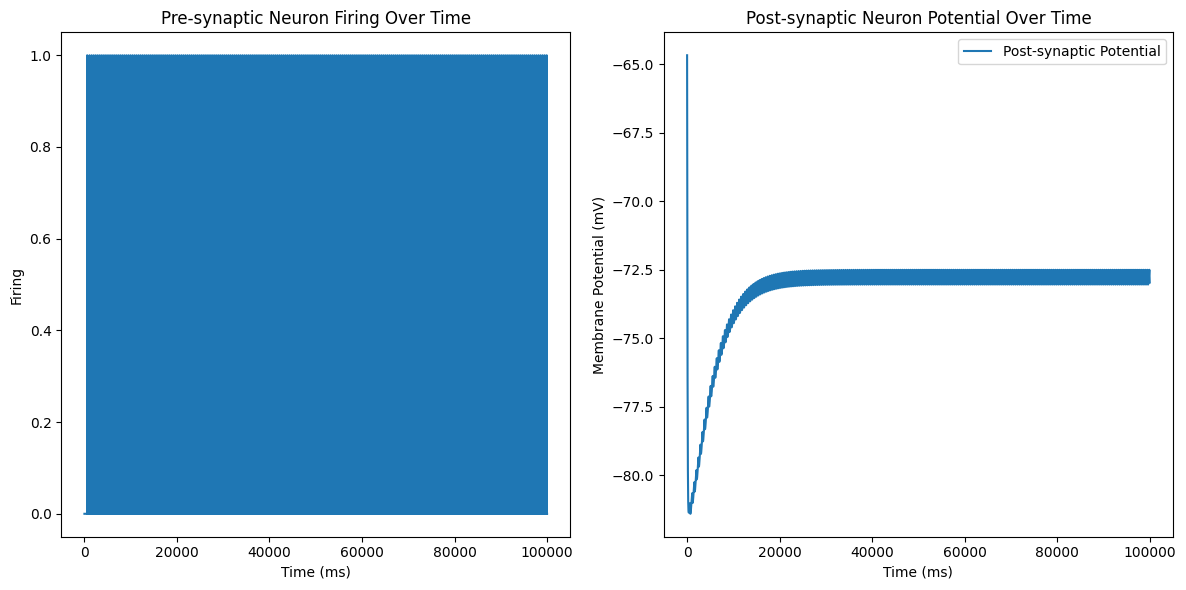

In [125]:
import random
import matplotlib.pyplot as plt


class TestTypedSynapse:
    def __init__(self, pre_neurone_type, post_neurone_type, delta_t=0.01, simulation_time=1000):
        self.pre_neurone = Neurone(pre_neurone_type, neurone_id=0)
        self.post_neurone = Neurone(post_neurone_type, neurone_id=1)
        self.synapse = TypedSynapse(self.pre_neurone, self.post_neurone, delta_t)
        self.delta_t = delta_t
        self.simulation_time = simulation_time
        self.pre_neurone_activity = []
        self.post_neurone_potentials = []

    def run_simulation(self, pre_neurone_current):
        for t in range(int(self.simulation_time / self.delta_t)):
            # Update the pre-synaptic neuron with constant current
            self.pre_neurone.update(pre_neurone_current, self.delta_t)
            self.pre_neurone_activity.append(self.pre_neurone.is_firing())
            self.post_neurone.update(0, delta_t=self.delta_t)

            # Update the synapse
            self.synapse.update()

            # Record the post-synaptic neuron's potential
            self.post_neurone_potentials.append(self.post_neurone.v_now)

    def plot_results(self):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.pre_neurone_activity, label='Pre-synaptic Activity')
        plt.title('Pre-synaptic Neuron Firing Over Time')
        plt.xlabel('Time (ms)')
        plt.ylabel('Firing')

        plt.subplot(1, 2, 2)
        plt.plot(self.post_neurone_potentials, label='Post-synaptic Potential')
        plt.title('Post-synaptic Neuron Potential Over Time')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')

        plt.tight_layout()
        plt.legend()
        plt.show()

    def test_synapse(self, pre_neurone_current):
        print(f"Testing synapse with {self.pre_neurone.neurone_type} -> {self.post_neurone.neurone_type}")
        self.run_simulation(pre_neurone_current)
        self.plot_results()

# Usage
test = TestTypedSynapse("EXCITATORY", "INHIBITORY")
test.test_synapse(pre_neurone_current=15)  # Apply a constant current known to induce firing
test1 = TestTypedSynapse("INHIBITORY", "INHIBITORY")
test1.test_synapse(pre_neurone_current=15)  # Apply a constant current known to induce firing
test2 = TestTypedSynapse("EXCITATORY", "EXCITATORY")
test2.test_synapse(pre_neurone_current=15)  # Apply a constant current known to induce firing
test3 = TestTypedSynapse("INHIBITORY", "EXCITATORY")
test3.test_synapse(pre_neurone_current=15)  # Apply a constant current known to induce firing
test4 = TestTypedSynapse("INHIBITORY", "EXCITATORY")
test4.test_synapse(pre_neurone_current=15)  # Apply a constant current known to induce firing
test5 = TestTypedSynapse("INHIBITORY", "EXCITATORY")
test5.test_synapse(pre_neurone_current=15)  # Apply a constant current known to induce firing

Testing complex synapse network with pre-synaptic types: ['INHIBITORY', 'INHIBITORY', 'INHIBITORY', 'INHIBITORY', 'INHIBITORY', 'INHIBITORY', 'INHIBITORY', 'INHIBITORY', 'INHIBITORY', 'INHIBITORY'] -> EXCITATORY post-synaptic


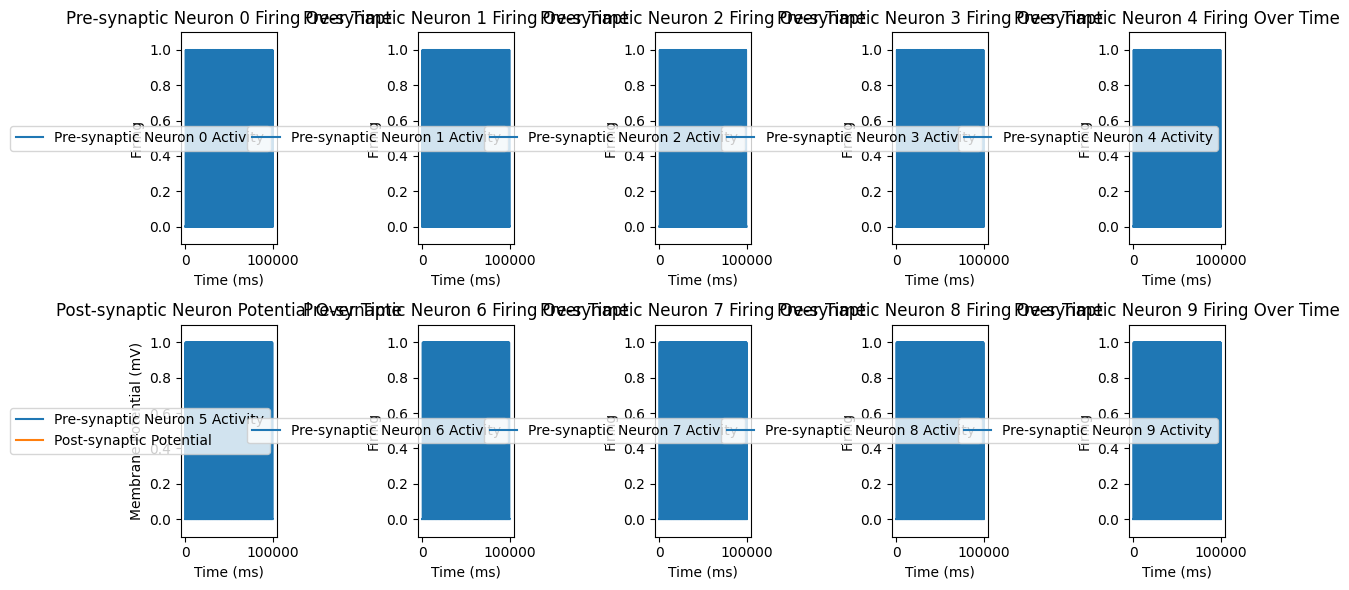

In [129]:
import random
import matplotlib.pyplot as plt

class TestComplexSynapseNetwork:
    def __init__(self, pre_neurone_types, post_neurone_type, delta_t=0.01, simulation_time=1000):
        self.pre_neurons = [Neurone(neurone_type, neurone_id=i) for i, neurone_type in enumerate(pre_neurone_types)]
        self.post_neurone = Neurone(post_neurone_type, neurone_id=len(pre_neurone_types))
        self.synapses = [TypedSynapse(pre_neurone, self.post_neurone, delta_t) for pre_neurone in self.pre_neurons]
        self.delta_t = delta_t
        self.simulation_time = simulation_time
        self.pre_neurone_activity = [[] for _ in range(len(self.pre_neurons))]
        self.post_neurone_potentials = []

    def run_simulation(self, pre_neurone_current):
        for t in range(int(self.simulation_time / self.delta_t)):
            # Update each pre-synaptic neuron with constant current
            for i, pre_neurone in enumerate(self.pre_neurons):
                pre_neurone.update(pre_neurone_current, self.delta_t)
                self.pre_neurone_activity[i].append(pre_neurone.is_firing())

            # Update all synapses
            for synapse in self.synapses:
                synapse.update()

            # Update the post-synaptic neuron after synapse updates
            self.post_neurone.update(0, delta_t=self.delta_t)

            # Record the post-synaptic neuron's potential
            self.post_neurone_potentials.append(self.post_neurone.v_now)

    def plot_results(self):
        num_pre_neurons = len(self.pre_neurons)

        # Calculate number of rows needed: One row for pre-neurons and one for post-neuron
        num_rows = 2
        # Number of columns is determined by the number of pre-neurons
        num_cols = (num_pre_neurons + 1) // 2 if num_pre_neurons > 1 else 1

        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))
        axs = axs.flatten()  # Flatten in case it's a 2D array

        # Plot pre-synaptic neuron activity in the first row
        for i, activity in enumerate(self.pre_neurone_activity):
            row_index = i // num_cols
            col_index = i % num_cols
            ax = axs[row_index * num_cols + col_index]
            ax.plot(activity, label=f'Pre-synaptic Neuron {i} Activity')
            ax.set_title(f'Pre-synaptic Neuron {i} Firing Over Time')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Firing')
            ax.set_ylim(-0.1, 1.1)
            ax.legend()

        # Plot post-synaptic neuron potential on a new line (second row)
        post_ax = axs[num_cols]  # First subplot of the second row
        post_ax.plot(self.post_neurone_potentials, label='Post-synaptic Potential')
        post_ax.set_title('Post-synaptic Neuron Potential Over Time')
        post_ax.set_xlabel('Time (ms)')
        post_ax.set_ylabel('Membrane Potential (mV)')
        post_ax.legend()

        plt.tight_layout()
        plt.show()

    def test_network(self, pre_neurone_current):
        print(f"Testing complex synapse network with pre-synaptic types: {[n.neurone_type for n in self.pre_neurons]} -> {self.post_neurone.neurone_type} post-synaptic")
        self.run_simulation(pre_neurone_current)
        self.plot_results()

# Usage
pre_neurone_types = ["INHIBITORY" for i in range(10)]
test_network = TestComplexSynapseNetwork(pre_neurone_types, "EXCITATORY")
test_network.test_network(pre_neurone_current=15)  # Apply a constant current known to induce firing

# Modular Network Experiment.

If we beign with 8 excitatory pools, each interconnected with each other.

In [184]:
from concurrent.futures import ThreadPoolExecutor

class ModularNetworksExperiment:
    def __init__(self, p, delta_t, simulation_time):
        self.p = p
        self.delta_t = delta_t
        self.simulation_time = simulation_time

        self.recordings_v = [[] for _ in range(1000)] # using 1,000 neurones for this
        self.recordings_u = [[] for _ in range(1000)]

        self.neurones = []
        self.synapses = []
        self.adjacency_matrix = [] # adjacency_matrix[i][j] represents connection between i and j, where i is pre synaptic neurone and j is the post synaptic neurone. It stores the index of the synapse
        self.create_networks()
        self.join_neurones()

    def create_networks(self):
        # 8 Communities of excitatory neurons
        self.neurones = [Neurone("EXCITATORY", i) for i in range(800)]
        # 1 Pool of Inhibitary Neurones
        self.neurones += [Neurone("INHIBITORY", i+800) for i in range(200)]
        self.adjacency_matrix = [[None for _ in range(1000)] for _ in range(1000)]

    def join_neurones(self):
        # Create a modular network. - Excitatory - Excitatory Nodes
        for module_number in range(8):
            # Each module has 1,000 randomly asigned Excitatory to Excitatory Synapses
            neurones_in_module = self.neurones[module_number*100: (module_number+1)*100]
            for i in range(1000):
                [pre_synaptic_neurone, post_synaptic_neurone] = random.sample(neurones_in_module, 2)
                synapse = TypedSynapse(pre_synaptic_neurone, post_synaptic_neurone, delta_t=self.delta_t)
                self.synapses.append(synapse)
                self.adjacency_matrix[pre_synaptic_neurone.neurone_id][post_synaptic_neurone.neurone_id] = len(self.synapses) - 1


        all_modules = set(range(0, 8))

        # Rewire the synapse
        for i, synapse in enumerate(self.synapses):
            if random.random() < self.p:
                # get post_synpatic index
                [pre_neurone_id, post_neurone_id] = synapse.connection
                other_modules = all_modules - {post_neurone_id//100}
                old_synpase_position = self.adjacency_matrix[pre_neurone_id][post_neurone_id]
                self.adjacency_matrix[pre_neurone_id][post_neurone_id] = None
                other_module = random.choice(list(other_modules))
                new_post_neurone = self.neurones[other_module*100 + random.randint(0, 99)]
                synapse.rewire_synapse(self.neurones[pre_neurone_id], new_post_neurone)
                self.adjacency_matrix[pre_neurone_id][new_post_neurone.neurone_id] = old_synpase_position

        # Each inhibitory neurone goes to every excitatory neurone
        for i in range(800, 1000):
            inhibitary_neurone = self.neurones[i]
            for j in range(1000):
                if i == j:
                    continue
                excitatory_neurone = self.neurones[j]
                synapse = TypedSynapse(inhibitary_neurone, excitatory_neurone, delta_t=self.delta_t)
                self.synapses.append(synapse)
                self.adjacency_matrix[inhibitary_neurone.neurone_id][excitatory_neurone.neurone_id] = len(self.synapses) - 1

            module_number = random.randint(0,7)
            selected_neurone_ids = [random.randint(module_number*100, (module_number+1)* 100) for _ in range(4)]
            for selected_neurone_id in selected_neurone_ids:
                synapse = TypedSynapse(self.neurones[selected_neurone_id], inhibitary_neurone, delta_t=self.delta_t)
                self.synapses.append(synapse)
                self.adjacency_matrix[selected_neurone_id][inhibitary_neurone.neurone_id] = len(self.synapses) - 1

    def plot_adjacency_matrix(self):
        plot_matrix = np.array([[0 if value is None else 1 for value in row] for row in self.adjacency_matrix])
        plt.figure(figsize=(10, 10))
        plt.imshow(plot_matrix, cmap='Greys', interpolation='none')
        plt.colorbar()
        plt.title('Neural Network Adjacency Matrix')
        plt.xlabel('Neuron j')
        plt.ylabel('Neuron i')
        # Turn off the axis ticks if you prefer a cleaner look
        plt.xticks([])
        plt.yticks([])

        # Show the plot
        plt.show()

    def update_neuron_chunk(self, neuron_indices, external_currents):
        for i in neuron_indices:
            v, u, is_firing = self.neurones[i].update(delta_t=self.delta_t, external_current=external_currents[i])
            self.recordings_v[i].append(v)
            self.recordings_u[i].append(u)

    def update_synapse_chunk(self, synapse_indices):
        for i in synapse_indices:
            self.synapses[i].update()

    def update(self, external_currents, neurone_per_thread, synapse_per_thread):
        num_neurons = len(self.neurones)
        chunk_size = neurone_per_thread  # Update 20 neurons at a time
        num_synapses = len(self.synapses)
        synapse_chunk_size = synapse_per_thread  # Update 20 synapses at a time


        # Create chunks of neuron indices
        neuron_chunks = [range(i, min(i + chunk_size, num_neurons)) for i in range(0, num_neurons, chunk_size)]
        synapse_chunks = [range(i, min(i + synapse_chunk_size, num_synapses)) for i in range(0, num_synapses, synapse_chunk_size)]


        # Update chunks of neurons concurrently
        with ThreadPoolExecutor() as executor:
            executor.map(lambda chunk: self.update_neuron_chunk(chunk, external_currents), neuron_chunks)

        with ThreadPoolExecutor() as executor:
            executor.map(self.update_synapse_chunk, synapse_chunks)

    def run_simulation(self, simulation_time, neurone_per_thread, synapse_per_thread):
        total_steps = int(simulation_time / self.delta_t)
        numerical_step = int(1 / self.delta_t)
        for sim_time in range(simulation_time):
            # update background current for neurones
            external_currents = [15 if np.random.poisson(0.01) > 0 else 0 for i in range(len(self.neurones))]

            for delta_step in range(numerical_step):
                t = sim_time*numerical_step + delta_step
                self.update(external_currents, neurone_per_thread, synapse_per_thread)
                # Progress bar
                progress = (t + 1) / total_steps
                print(f'\rSimulation progress: {progress:.2%}', end='')

# The Network Adjaceny Matrix

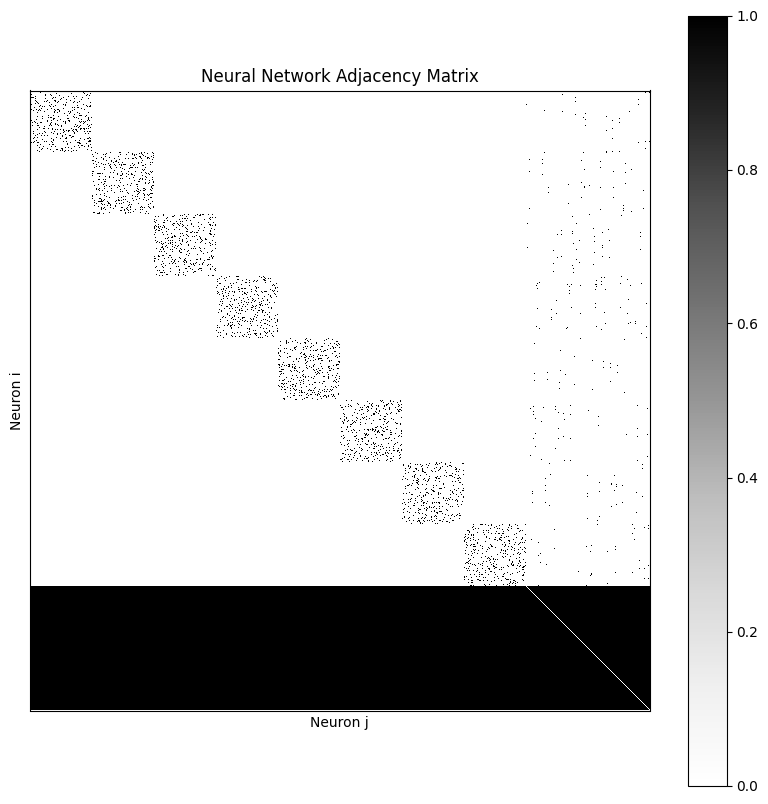

In [185]:
module = ModularNetworksExperiment(p=0, delta_t=0.01, simulation_time=1000)
module.plot_adjacency_matrix()

In [182]:
module.run_simulation(1, 500, 500)

Simulation progress: 100.00%

# Plotting the Results of the simulation

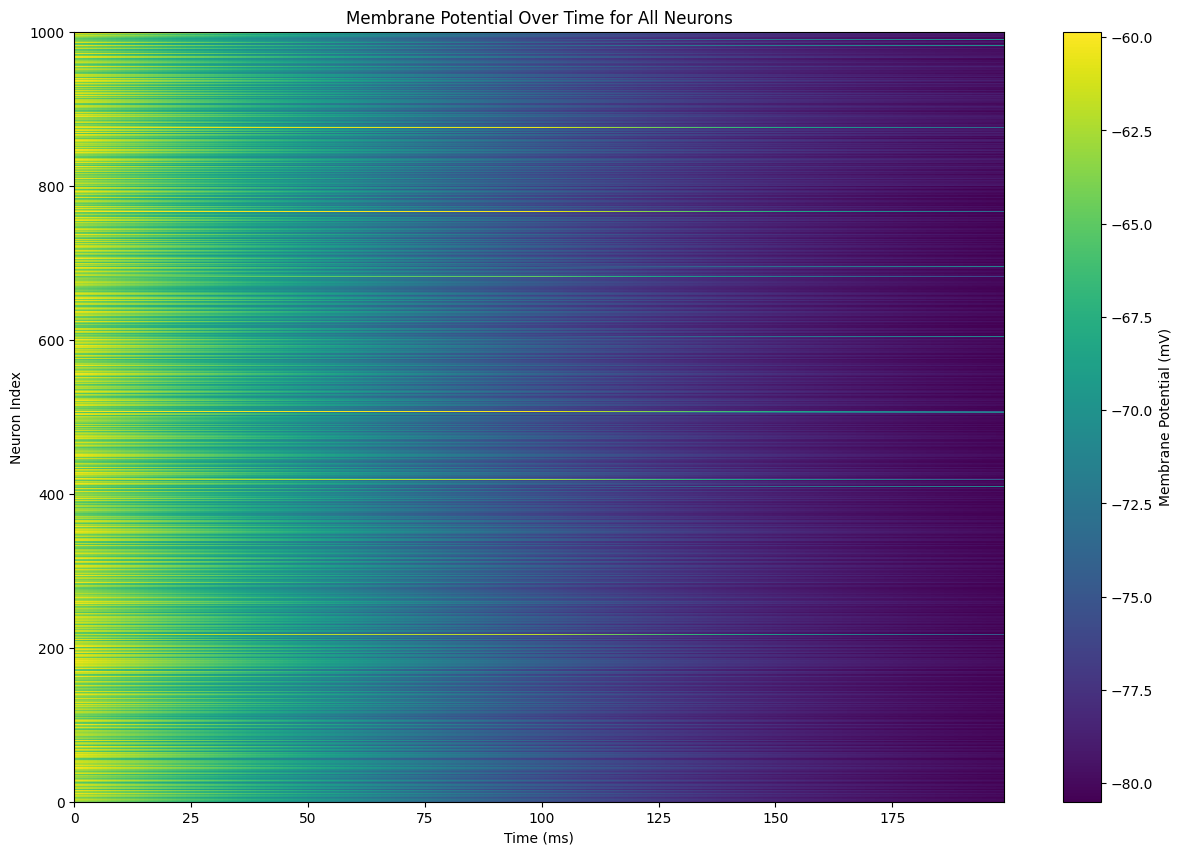

In [183]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is a 2D NumPy array where rows correspond to neurons and columns correspond to time points
# Convert your recordings to a NumPy array if it isn't already
data = np.array(module.recordings_v)

delta_t = 1  # Time step
time_points = np.arange(data.shape[1]) * delta_t  # Calculate actual time points

# Set up the figure
plt.figure(figsize=(15, 10))

# Use imshow to create the heatmap for the membrane potential
plt.imshow(data, aspect='auto', origin='lower', cmap='viridis', interpolation='none', extent=[0, time_points[-1], 0, data.shape[0]])
plt.colorbar(label='Membrane Potential (mV)')  # Add a colorbar for reference

# Overlay the spikes
# Iterate over each neuron's data
for neuron_idx, neuron_data in enumerate(data):
    # Find the time points where the potential is greater than 20
    spike_times = np.where(neuron_data > 20)[0] * delta_t  # Adjust spike times for delta_t
    # Plot these as larger blue points
    plt.scatter(spike_times, np.full_like(spike_times, neuron_idx), color='blue', s=10)  # s is the size of the point

# Label the axes and add a title
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Membrane Potential Over Time for All Neurons')

# Show the plot
plt.show()


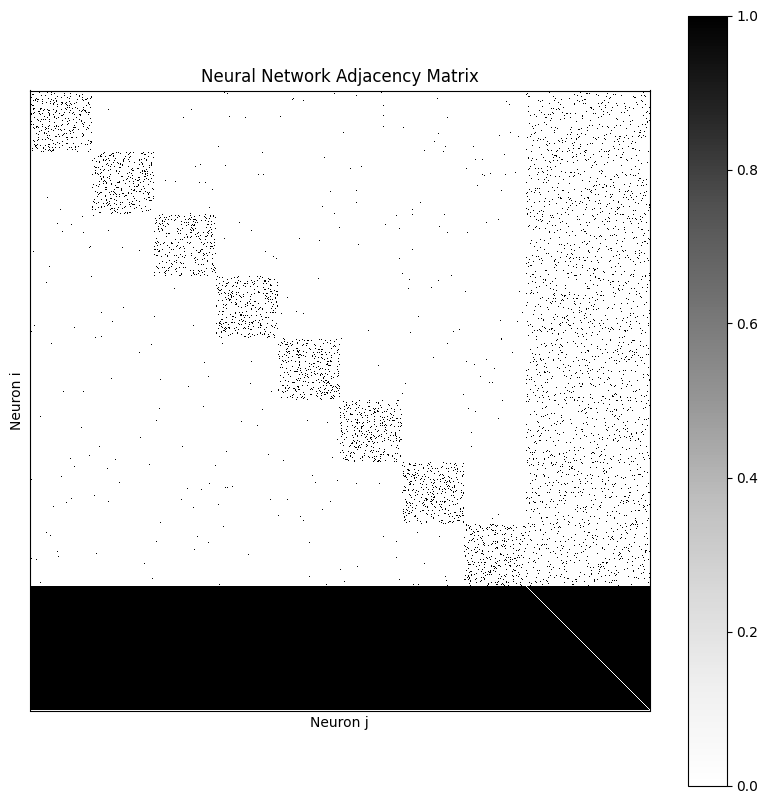

In [152]:
module = ModularNetworksExperiment(p=0.1, delta_t=0.01, simulation_time=1000)
module.plot_adjacency_matrix()

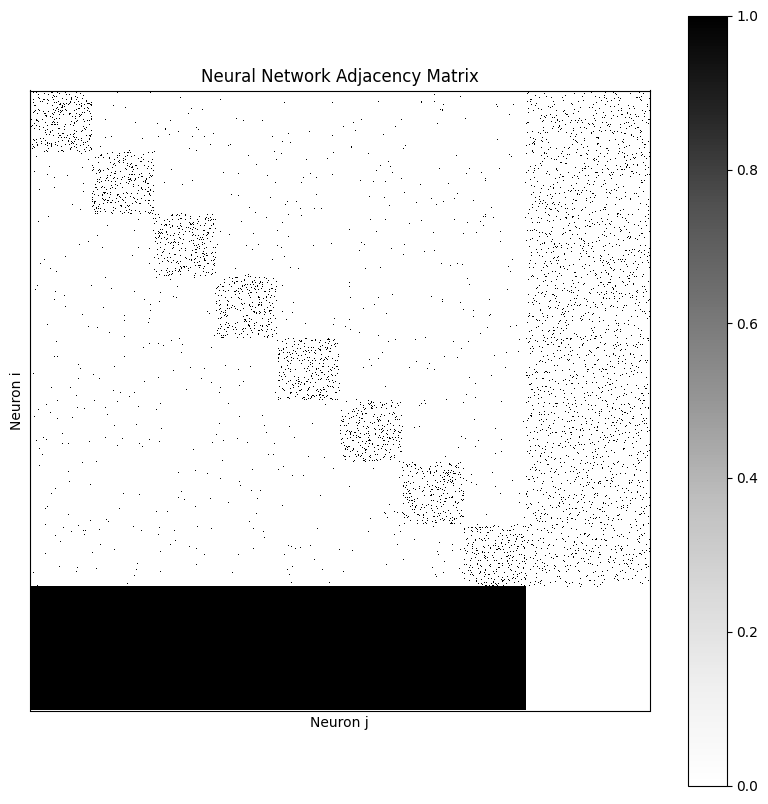

In [137]:
module = ModularNetworksExperiment(p=0.2, delta_t=0.01, simulation_time=1000)
module.plot_adjacency_matrix()

# "It shouldn't take that long" - Adhithi

Okay buddy I'm listening, and I hear you.

**What's the solution?**

The solution here is gotta be making the most of numpy's vector operations? I think... Yeah no I'm probably right here...
- neurones -> variables in the class
- synapse should be variables in the class too..
- dela_t complications... Let's abstract away from what delta_t actually means. We only call update neurone and update synapse every 1ms...

In [4]:
from collections import deque
import numpy as np
import random

class NewModulularNetwork:
    def __init__(self, p, simulation_time, delta_t):
        self.p = p
        self.delta_t = delta_t
        self.simulation_time = simulation_time

        self.recordings_v = [[] for _ in range(1000)] # using 1,000 neurones for this
        self.recordings_u = [[] for _ in range(1000)]

        # DEPRECATED - self.neurones = []
        # New Neurone Implementation
        self._max_neurone_potential = 30
        self.v_now = None
        self.u_now = None
        self.I_now = None
        self.firing = None
        self.a = None
        self.b = None
        self.c = None
        self.d = None

        print("Initialising Neurones")
        self.initialise_neurones()
        print("Neurones Initialised!")

        # DEPRECATED - self.synapses = []
        # New Synapse
        self.synaptic_weights = None
        self.scaling_factors = None
        self.conduction_delays = None
        self.conduction_queue = None
        self.pre_synaptic_neurones = None
        self.post_synaptic_neurones = None
        self.synaptic_efficacy = None
        self.adjacency_matrix = [[None for _ in range(1000)] for _ in range(1000)]
        self.decay_factor = 0.5

        print("Initialising Synapses")
        self.initialise_synapses()
        print("Synapses Initialised!")


    def initialize_neuron_parameters(self, num_excitatory, num_inhibitory):
        # Vectorized initialization of parameters
        r = np.random.random(num_excitatory + num_inhibitory)

        # a Parameter
        a_excitatory = 0.02 * np.ones(num_excitatory)
        a_inhibitory = 0.02 + 0.08 * np.square(r[num_excitatory:])
        a = np.concatenate([a_excitatory, a_inhibitory])

        # b parameter
        b_excitatory = 0.2 * np.ones(num_excitatory)
        b_inhibitory = 0.25 - 0.05 * r[num_excitatory:]
        b = np.concatenate([b_excitatory, b_inhibitory])

        # c parameter
        c_excitatory = -65 + 15 * np.square(r[:num_excitatory])
        c_inhibitory = -65 * np.ones(num_inhibitory)
        c = np.concatenate([c_excitatory, c_inhibitory])

        # d parameter
        d_excitatory = 8 - 6 * np.square(r[:num_excitatory])
        d_inhibitory = 2 * np.ones(num_inhibitory)
        d = np.concatenate([d_excitatory, d_inhibitory])

        return a, b, c, d

    def initialise_neurones(self):
        num_neurons = 1000
        num_excitatory = 800
        num_inhibitory = 200

        # Initialize neuron parameters
        self.v_now = np.random.uniform(-65, -60, num_neurons)
        self.u_now = -1 * np.ones(num_neurons)
        self.I_now = np.zeros(num_neurons)
        self.firing = np.zeros(num_neurons, dtype=bool)

        # Neuron type specific parameters
        a, b, c, d = self.initialize_neuron_parameters(num_excitatory, num_inhibitory)
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        return None

    def update_neurons(self, external_currents, delta_t=0.01):
        # Number of updates within 1ms
        num_updates = int(1.0 / delta_t)

        # Update currents
        self.I_now += external_currents
        recordings_v = []
        recordings_u = []

        self.firing = np.zeros((num_updates, 1000), dtype=bool)

        # Perform updates for each small timestep within 1ms
        for time_step in range(num_updates):
            # Vectorized update
            dv_dt = 0.04 * self.v_now**2 + 5 * self.v_now + 140 - self.u_now + self.I_now
            du_dt = self.a * (self.b * self.v_now - self.u_now)

            self.v_now += delta_t * dv_dt
            self.u_now += delta_t * du_dt

            # Check for firing neurons
            firing_neurons = self.v_now >= self._max_neurone_potential
            self.v_now[firing_neurons] = self.c[firing_neurons]
            self.u_now[firing_neurons] += self.d[firing_neurons]


            recordings_v.append(self.v_now.copy())
            recordings_u.append(self.u_now.copy())

            self.firing[time_step] = firing_neurons


        self.firing = np.any(self.firing, axis=0)
        # Reset Currents
        self.I_now = np.zeros_like(self.I_now)

        # Extend the historical recordings with new data
        for neuron_id in range(1000):
            self.recordings_v[neuron_id].extend([v[neuron_id] for v in recordings_v])
            self.recordings_u[neuron_id].extend([u[neuron_id] for u in recordings_u])

        return self.v_now, self.u_now, self.firing


    def initialise_synapse_params(self, synapes):
        def get_synapse_params(pre_neurone_type, post_neurone_type):
            if pre_neurone_type == "EXCITATORY":
                if post_neurone_type == "INHIBITORY":
                    return random.random(), 50, 1
                else:
                    return 1, 17, random.randint(1,20)
            else:
                if post_neurone_type == "INHIBITORY":
                    return -random.random(), 1, 1
                else:
                    return -random.random(), 2, 1

        weights = []
        scalings = []
        delays = []
        conduction_queue = []
        for index, synapse in enumerate(synapes):
            pre_synapse_type = "EXCITATORY" if synapse[0] <800 else "INHIBITORY"
            post_synapse_type = "EXCITATORY" if synapse[0] <800 else "INHIBITORY"
            weight, scaling, delay = get_synapse_params(pre_synapse_type, post_synapse_type)
            weights.append(weight)
            scalings.append(scaling)
            delays.append(delay)
            self.adjacency_matrix[synapse[0]][synapse[1]] = index
            conduction_queue.append(deque([0 for i in range(delay)], maxlen=delay))

        self.synaptic_weights = np.array(weights)
        self.scaling_factors = np.array(scalings)
        self.conduction_delays = np.array(delays)
        self.conduction_queue = conduction_queue


    def initialise_synapses(self):
        # To make this more efficient, let's define the connections first in terms of index -> index
        synapses = []

        for module_number in range(8):
            pre_synpatic_neurones = np.random.randint(0, 99, 1000) + (module_number * 100)
            for i in pre_synpatic_neurones:
                post_synaptic_neurone = random.randint(0, 99) + (module_number * 100)
                while i == post_synaptic_neurone:
                    post_synaptic_neurone = random.randint(0, 99) + (module_number * 100)
                synapses.append((i, post_synaptic_neurone))

        all_modules = set(range(0, 8))

        # Rewire these neurone connections
        for index, synapse in enumerate(synapses):
            if random.random() < self.p:
                [_, post_neurone_id] = synapse
                other_modules = all_modules - {post_neurone_id//100}
                new_post_neurone = other_modules*100 + random.randint(0, 99)
                synapses[index][1] = new_post_neurone

        for i in range(800, 1000):
            for j in range(1000):
                if i == j:
                    continue
                synapses.append((i,j))

            module_number = random.randint(0,7)
            selected_neurone_ids = [random.randint(module_number*100, (module_number+1)* 100) for _ in range(4)]
            for selected_pre_neurone in selected_neurone_ids:
                synapses.append((selected_pre_neurone, i))

        self.pre_synaptic_neurones = np.array([synapses[i][0] for i in range(len(synapses))])
        self.post_synaptic_neurones = np.array([synapses[i][1] for i in range(len(synapses))])
        self.synaptic_efficacy = np.zeros(len(synapses), dtype=np.float64)
        self.initialise_synapse_params(synapses)

    def update_synapse(self):
        # Apply decay to all synaptic efficacies
        self.synaptic_efficacy *= self.decay_factor

        # Handle the pre-synaptic neuron firing and update synaptic efficacy
        for i, queue in enumerate(self.conduction_queue):
            pre_neurone_id = self.pre_synaptic_neurones[i]
            post_neurone_id = self.post_synaptic_neurones[i]

            # Check if pre-synaptic neuron is firing
            if self.firing[pre_neurone_id]:
                queue.append(1)
            else:
                queue.append(0)

            # Check if a new spike has arrived (based on conduction delay)
            if queue.popleft():
                self.synaptic_efficacy[i] += self.synaptic_weights[i]

            # Apply the current synaptic efficacy to the post-synaptic neuron
            # Note: This will require accumulating the input from all synapses for each neuron
            self.I_now[post_neurone_id] += self.synaptic_efficacy[i] * self.scaling_factors[i]

    def run_simulation(self):
        for sim_time in range(self.simulation_time):
            # Update background current for neurons as a NumPy array
            external_currents = np.array([15 if np.random.poisson(0.01) > 0 else 0 for _ in range(1000)])
            # Update neurons and synapses
            self.update_neurons(external_currents)
            self.update_synapse()
            progress = (sim_time + 1) / self.simulation_time
            print(f'\rSimulation progress: {progress:.2%}', end='')

    def plot_adjacency_matrix(self):
        plot_matrix = np.array([[0 if value is None else 1 for value in row] for row in self.adjacency_matrix])
        plt.figure(figsize=(10, 10))
        plt.imshow(plot_matrix, cmap='Greys', interpolation='none')
        plt.colorbar()
        plt.title('Neural Network Adjacency Matrix')
        plt.xlabel('Neuron j')
        plt.ylabel('Neuron i')
        # Turn off the axis ticks if you prefer a cleaner look
        plt.xticks([])
        plt.yticks([])

        # Show the plot
        plt.show()

    def plot_rassta_plots(self):
        # Assuming 'data' is a 2D NumPy array where rows correspond to neurons and columns correspond to time points
        # Convert your recordings to a NumPy array if it isn't already
        data = self.recordings_v[:800]

        delta_t = self.delta_t  # Time step
        time_points = np.arange(data.shape[1]) * delta_t  # Calculate actual time points

        # Set up the figure
        plt.figure(figsize=(15, 10))

        # Use imshow to create the heatmap for the membrane potential
        plt.imshow(data, aspect='auto', origin='lower', cmap='viridis', interpolation='none', extent=[0, time_points[-1], 0, data.shape[0]])
        plt.colorbar(label='Membrane Potential (mV)')  # Add a colorbar for reference

        # Overlay the spikes
        # Iterate over each neuron's data
        for neuron_idx, neuron_data in enumerate(data):
            # Find the time points where the potential is greater than 20
            spike_times = np.where(neuron_data > 20)[0] * delta_t  # Adjust spike times for delta_t
            # Plot these as larger blue points
            plt.scatter(spike_times, np.full_like(spike_times, neuron_idx), color='blue', s=10)  # s is the size of the point

        # Label the axes and add a title
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron Index')
        plt.title('Membrane Potential Over Time for All Neurons')

        # Show the plot
        plt.show()



In [5]:
module = NewModulularNetwork(0, 1000, 0.01)

Initialising Neurones
Neurones Initialised!
Initialising Synapses
Synapses Initialised!


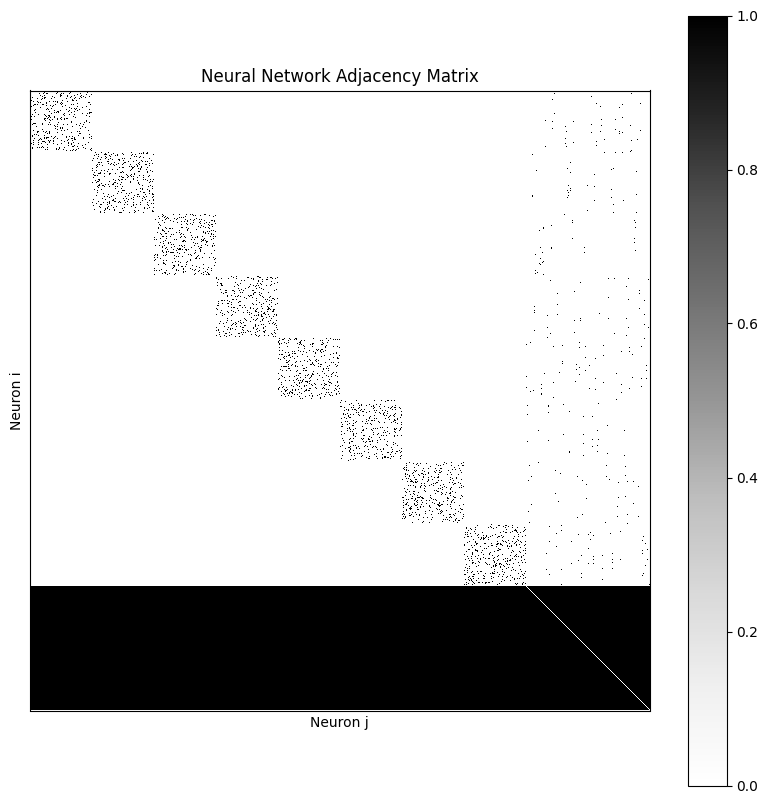

In [6]:
module.plot_adjacency_matrix()

In [7]:
module.run_simulation()

Simulation progress: 100.00%

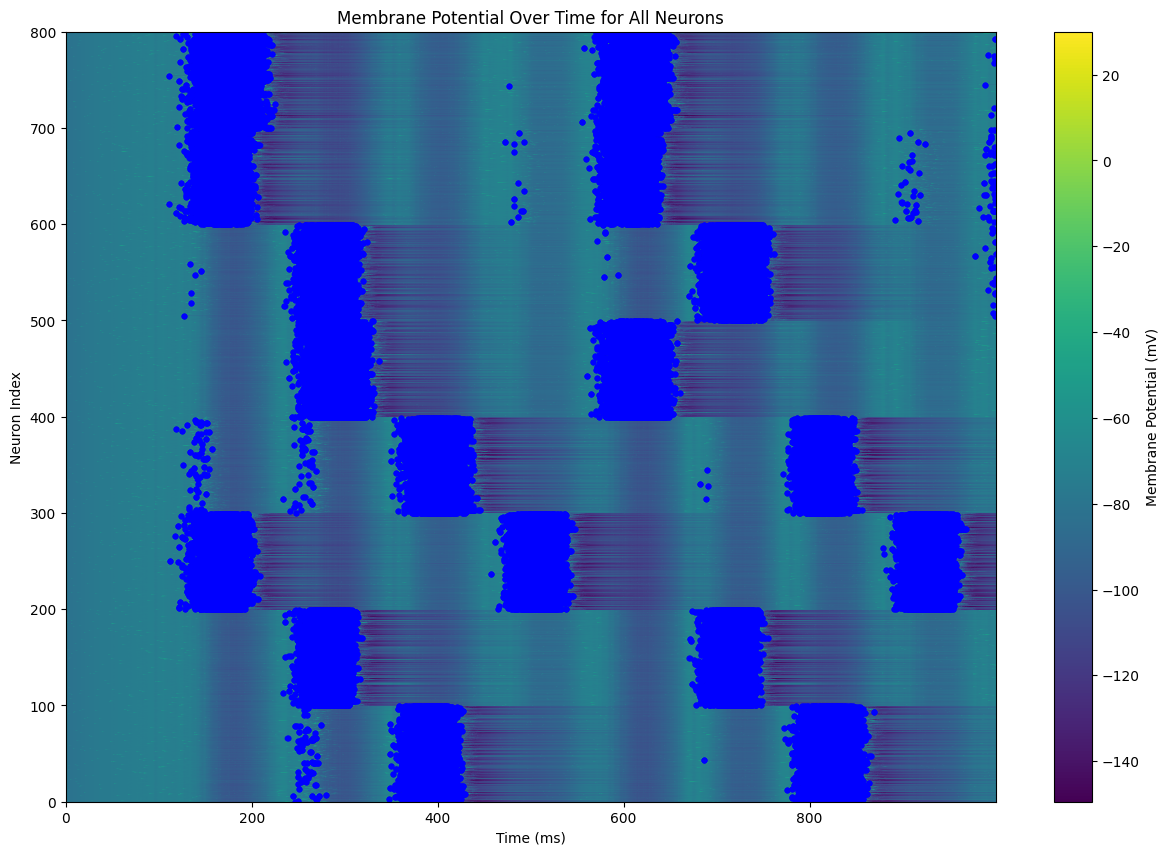

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Assuming 'data' is a 2D NumPy array where rows correspond to neurons and columns correspond to time points
# Convert your recordings to a NumPy array if it isn't already
data = np.array(module.recordings_v[:800])

delta_t = 0.01  # Time step
time_points = np.arange(data.shape[1]) * delta_t  # Calculate actual time points

# Set up the figure
plt.figure(figsize=(15, 10))

# Use imshow to create the heatmap for the membrane potential
plt.imshow(data, aspect='auto', origin='lower', cmap='viridis', interpolation='none', extent=[0, time_points[-1], 0, data.shape[0]])
plt.colorbar(label='Membrane Potential (mV)')  # Add a colorbar for reference

# Overlay the spikes
# Iterate over each neuron's data
for neuron_idx, neuron_data in enumerate(data):
    # Find the time points where the potential is greater than 20
    spike_times = np.where(neuron_data > 20)[0] * delta_t  # Adjust spike times for delta_t
    # Plot these as larger blue points
    plt.scatter(spike_times, np.full_like(spike_times, neuron_idx), color='blue', s=10)  # s is the size of the point

# Label the axes and add a title
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Membrane Potential Over Time for All Neurons')

# Show the plot
plt.show()
